## Inverse Cooking: Recipe Generation from Food Images

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import os
from args import get_parser
import pickle
from model import get_model
from torchvision import transforms
from utils.output_utils import prepare_output
from PIL import Image
import time
from build_vocab import Vocabulary

Set ```data_dir``` to the path including vocabularies and model checkpoint

In [2]:
data_dir = '../data'

In [3]:
# code will run in gpu if available and if the flag is set to True, else it will run on cpu
use_gpu = True
device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
map_loc = None if torch.cuda.is_available() and use_gpu else 'cpu'

In [4]:
# code below was used to save vocab files so that they can be loaded without Vocabulary class
ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'recipe1m_vocab_ingrs.pkl'), 'rb'))
# ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_ingrs.pkl'), 'rb'))
ingrs_vocab = [min(w, key=len) if not isinstance(w, str) else w for w in ingrs_vocab.idx2word.values()]
vocab = pickle.load(open(os.path.join(data_dir, 'recipe1m_vocab_toks.pkl'), 'rb')).idx2word
# vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_toks.pkl'), 'rb')).idx2word
pickle.dump(ingrs_vocab, open('../demo/ingr_vocab.pkl', 'wb'))
pickle.dump(vocab, open('../demo/instr_vocab.pkl', 'wb'))

# ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'ingr_vocab.pkl'), 'rb'))
# vocab = pickle.load(open(os.path.join(data_dir, 'instr_vocab.pkl'), 'rb'))

ingr_vocab_size = len(ingrs_vocab)
instrs_vocab_size = len(vocab)
output_dim = instrs_vocab_size

In [5]:
print (instrs_vocab_size, ingr_vocab_size)

7608 754


In [6]:
t = time.time()
import sys; sys.argv=['']; del sys
args = get_parser()
args.maxseqlen = 15
args.ingrs_only=False
model = get_model(args, ingr_vocab_size, instrs_vocab_size)
# Load the trained model parameters
model_path = os.path.join(data_dir, 'modelbest.ckpt')
model.load_state_dict(torch.load(model_path, map_location=map_loc))
model.to(device)
model.eval()
model.ingrs_only = False
model.recipe_only = False
print ('loaded model')
print ("Elapsed time:", time.time() -t)


/data/envs/recipe/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


loaded model
Elapsed time: 7.541977405548096


In [7]:
transf_list_batch = []
transf_list_batch.append(transforms.ToTensor())
transf_list_batch.append(transforms.Normalize((0.485, 0.456, 0.406), 
                                              (0.229, 0.224, 0.225)))
to_input_transf = transforms.Compose(transf_list_batch)

In [8]:
greedy = [True, False, False, False]
beam = [-1, -1, -1, -1]
temperature = 1.0
numgens = len(greedy)

Set ```use_urls = True``` to get recipes for images in ```demo_urls```. 

You can also set ```use_urls = False``` and get recipes for images in the path in ```data_dir/test_imgs```.

In [9]:
import requests
from io import BytesIO
import random
from collections import Counter
use_urls = False # set to true to load images from demo_urls instead of those in test_imgs folder
show_anyways = False #if True, it will show the recipe even if it's not valid
image_folder = os.path.join(data_dir, 'demo_imgs')
use_custom_imgs = True

if not use_urls:
    demo_imgs = os.listdir(image_folder)
    random.shuffle(demo_imgs)
if use_custom_imgs:
    demo_imgs = ['val/1/7/e/5/17e5ced833.jpg', 'val/4/3/a/9/43a9c3da7e.jpg', 'val/0/e/8/b/0e8bec249f.jpg', 'test/5/7/3/5/5735ac707c.jpg', 'val/c/6/8/c/c68cea19b5.jpg']
    demo_imgs = map(lambda x: os.path.join('../data/images/', x), demo_imgs)
    demo_imgs = list(demo_imgs)

demo_urls = ['https://food.fnr.sndimg.com/content/dam/images/food/fullset/2013/12/9/0/FNK_Cheesecake_s4x3.jpg.rend.hgtvcom.826.620.suffix/1387411272847.jpeg',
            'https://www.196flavors.com/wp-content/uploads/2014/10/california-roll-3-FP.jpg']

demo_files = demo_urls if use_urls else demo_imgs

Image path: ../data/images/val/1/7/e/5/17e5ced833.jpg


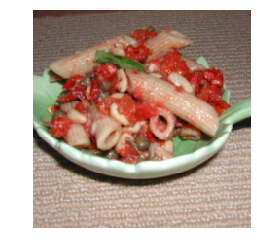

RECIPE 1

Title: Mediterranean pasta salad

Ingredients:
pepper, tomato, oil, onion, clove, basil, oregano, beans, salt, pasta

Instructions:
-Cook pasta according to package directions.
-Drain and rinse with cold water.
-Drain and set aside.
-In a large bowl, combine the tomatoes, green beans, onion, garlic, oregano, basil, salt, pepper, and olive oil.
-Toss to coat.
-Refrigerate for at least 1 hour before serving.
RECIPE 2

Title: Mediterranean pasta salad

Ingredients:
pepper, tomato, oil, onion, clove, basil, oregano, beans, salt, pasta

Instructions:
-Cook pasta to al dente.
-Rinse under cold water and drain well.
-Add olive oil and garlic and cook over low heat stirring occasionally until the garlic is lightly caramelized.
-Stir in green beans, tomatoes, basil and oregano.
-Sprinkle with salt and pepper to taste.
-Add pasta and toss to coat.
-Sprinkle with basil and oregano.
-Serve immediately.
-Note: this makes a lot of sauce, or freeze up to 1 week.
RECIPE 3

Title: Greek pasta

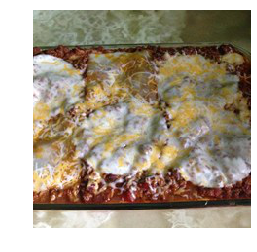

RECIPE 1

Title: Pizza casserole

Ingredients:
cheese, onion, tomato, pepper, beef, clove, basil, oregano, mushroom, oil, seasoning, water

Instructions:
-Preheat oven to 350 degrees f (175 degrees c).
-Grease a 9x13 inch baking dish.
-In a large skillet, brown beef, onion, garlic, and mushrooms.
-Drain excess fat.
-Stir in tomato sauce, tomato sauce, water, basil, oregano, basil, salt, pepper, and basil.
-Pour mixture into prepared baking dish.
-Bake in preheated oven for 30 minutes.
Not a valid recipe!
Reason:  no eos found
RECIPE 2

Title: Pizza casserole

Ingredients:
cheese, onion, tomato, pepper, beef, clove, basil, oregano, mushroom, oil, seasoning, water

Instructions:
-Cook beef, green pepper and garlic in a large skillet over medium-high heat until no longer pink; drain.
-Transfer meat, reserving 1 cup cooking liquid.
-Stir tomatoes, mushrooms, onion, oregano, basil, oil, and reserved liquid.
-Bring to boil; reduce heat, and simmer until thickened, stirring occasionally, abou

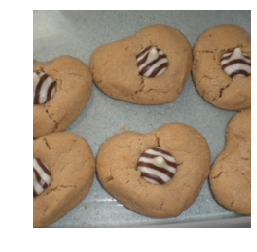

RECIPE 1

Title: Chocolate chip cookies

Ingredients:
sugar, flour, egg, butter, cocoa, baking_soda, salt, extract, chips, vanilla, cinnamon

Instructions:
-Preheat oven to 350 degrees f (175 degrees c).
-Grease cookie sheets.
-In a large bowl, cream together the butter and white sugar until light and fluffy.
-Beat in the egg and vanilla.
-Sift together the flour, cocoa, baking soda, salt, and cinnamon.
-Stir in the chocolate chips.
-Drop by rounded teaspoonfuls onto the prepared cookie sheets.
-Bake for 8 to 10 minutes in the preheated oven, or until lightly browned.
RECIPE 2

Title: Chewy chocolate chip cookies

Ingredients:
sugar, flour, egg, butter, cocoa, baking_soda, salt, extract, chips, vanilla, cinnamon

Instructions:
-In the bowl of a stand mixer fitted with the paddle attachment, cream the butter and sugar.
-Once combined, add the egg and vanilla and mix until combined.
-Slowly add the flour, baking soda and salt and mix until just incorporated.
-Add the baking soda and mix 

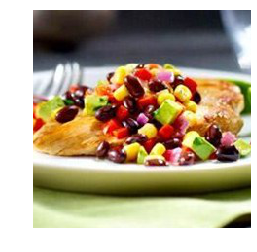

RECIPE 1

Title: Mexican corn tacos

Ingredients:
pepper, onion, corn, salt, oil, beans, cilantro, cumin, chili, sugar, juice, tortilla, cream, lime, jalapeno

Instructions:
-Heat the olive oil in a large skillet over medium heat.
-Add the onion and jalapeno and saute until the onion is translucent, about 5 minutes.
-Add the jalapeno, jalapeno, lime juice, salt, and sugar.
-Bring to a boil, reduce heat to low, and simmer until the corn is tender, about 15 minutes.
-Add the corn, beans, corn, and cilantro.
-Simmer until the corn is heated through, about 5 minutes.
-Serve with tortilla chips, or tortilla chips.
RECIPE 2

Title: Spicy corn fajitas

Ingredients:
pepper, onion, corn, salt, oil, beans, cilantro, cumin, chili, sugar, juice, tortilla, cream, lime, jalapeno

Instructions:
-Heat a large pot of water to a boil.
-Add beans, corn, onion, and cilantro.
-Cook and stir until vegetables are soft.
-Add sugar, lime juice, chili powder, cumin, and salt to taste.
-Bring to a boil, reduce h

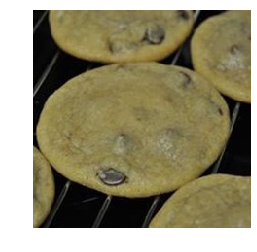

RECIPE 1

Title: Chocolate chip cookies

Ingredients:
sugar, flour, egg, butter, chips, baking_soda, extract, cream, vanilla, salt

Instructions:
-Preheat oven to 350 degrees f (175 degrees c).
-Grease cookie sheets.
-In a large bowl, cream together the butter and sugar until light and fluffy.
-Beat in the egg and vanilla.
-Stir in the flour, baking soda, and salt.
-Stir in the chocolate chips.
-Drop by rounded teaspoonfuls onto the prepared cookie sheets.
-Bake for 8 to 10 minutes in the preheated oven, or until lightly browned.
RECIPE 2

Title: Chocolate chip cookie mix cookies

Ingredients:
sugar, flour, egg, butter, chips, baking_soda, extract, cream, vanilla, salt

Instructions:
-Cream butter and sugar.
-Add egg and vanilla and beat well.
-In medium sized pan over medium heat add flour, baking soda, salt and chocolate chips.
-Stir til combined.
-Stir in butterscotch chips.
-Chill dough for 2 hours.
-Preheat oven to 400 degrees.
-Roll out dough and cut into desired size.
-Bake 10-1

In [13]:
for img_file in demo_files:
    
    if use_urls:
        response = requests.get(img_file)
        image = Image.open(BytesIO(response.content))
    else:
        if use_custom_imgs:
            image_path = img_file
        else:
            image_path = os.path.join(image_folder, img_file)
        image = Image.open(image_path).convert('RGB')
    
    transf_list = []
    transf_list.append(transforms.Resize(256))
    transf_list.append(transforms.CenterCrop(224))
    transform = transforms.Compose(transf_list)
    
    image_transf = transform(image)
    image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)
    
    print('Image path:', image_path)
    plt.imshow(image_transf)
    plt.axis('off')
    plt.show()
    plt.close()
    
    num_valid = 1
    for i in range(numgens):
        with torch.no_grad():
            outputs = model.sample(image_tensor, greedy=greedy[i], 
                                   temperature=temperature, beam=beam[i], true_ingrs=None)
            
        ingr_ids = outputs['ingr_ids'].cpu().numpy()
        recipe_ids = outputs['recipe_ids'].cpu().numpy()
            
        outs, valid = prepare_output(recipe_ids[0], ingr_ids[0], ingrs_vocab, vocab)
        
        if valid['is_valid'] or show_anyways:
            
            print ('RECIPE', num_valid)
            num_valid+=1
            #print ("greedy:", greedy[i], "beam:", beam[i])
    
            BOLD = '\033[1m'
            END = '\033[0m'
            print (BOLD + '\nTitle:' + END,outs['title'])

            print (BOLD + '\nIngredients:'+ END)
            print (', '.join(outs['ingrs']))

            print (BOLD + '\nInstructions:'+END)
            print ('-'+'\n-'.join(outs['recipe']))

            print ('='*20)

        else:
            pass
            print ("Not a valid recipe!")
            print ("Reason: ", valid['reason'])
        